In [1]:
import pandas as pd
import numpy as np

In [2]:
import datetime

# Data

data from https://github.com/openZH/covid_19


In [3]:
url = "https://raw.githubusercontent.com/openZH/covid_19/master/COVID19_Fallzahlen_CH_total.csv"

In [4]:
def pivot_data(data_frame, column_name):
    pivot = pd.DataFrame(pd.pivot_table(data_frame, values=column_name, index='date', columns=['abbreviation_canton_and_fl'], aggfunc=np.sum, dropna=True))
    new_df = pd.DataFrame(pivot.to_records())
    for col in new_df.columns[1:]:
        new_df.loc[new_df[col] == 0.0, col] = np.nan
    new_df.fillna(method='ffill', inplace=True)
    new_df['CH'] = new_df.sum(axis=1)
    return new_df

In [5]:
now  = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [6]:
df = pd.read_csv(url)

In [7]:
df.columns

Index(['date', 'time', 'abbreviation_canton_and_fl', 'ncumul_tested',
       'ncumul_conf', 'ncumul_hosp', 'ncumul_ICU', 'ncumul_vent',
       'ncumul_released', 'ncumul_deceased', 'source'],
      dtype='object')

In [8]:
df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')

In [9]:
df.loc[df['ncumul_conf'] == 0.0, 'ncumul_conf'] = np.nan

In [10]:
xl_writer = pd.ExcelWriter(f"covid19_swiss_data_{now}.xlsx")

In [11]:
df.to_excel(xl_writer, sheet_name="Raw")

In [12]:
cases = pivot_data(df, 'ncumul_conf')

In [13]:
cases.to_excel(xl_writer, "Infected")

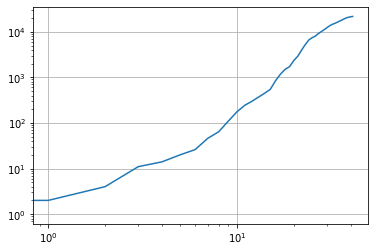

In [14]:
cases['CH'].plot(logy=True, logx=True, grid=True)

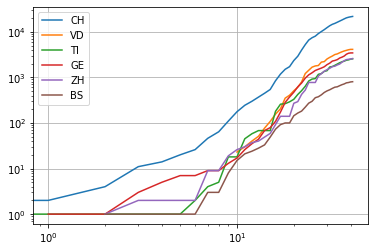

In [15]:
cases[['CH', 'VD', 'TI', 'GE', 'ZH', 'BS']].plot(logy=True, logx=True, grid=True)

In [16]:
deceased = pivot_data(df, 'ncumul_deceased')

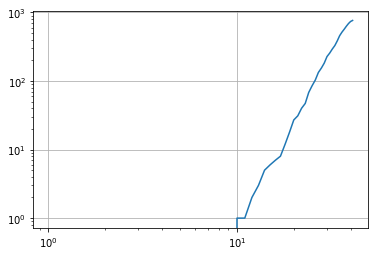

In [17]:
deceased['CH'].plot(logx=True, logy=True, grid=True)

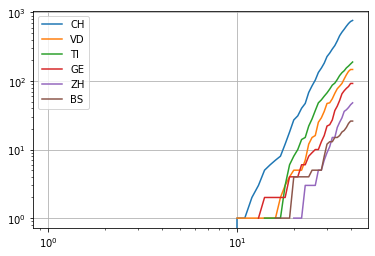

In [18]:
deceased[['CH', 'VD', 'TI', 'GE', 'ZH', 'BS']].plot(logy=True, logx=True, grid=True)

In [19]:
deceased.to_excel(xl_writer, "Deceased")

In [20]:
xl_writer.close()